In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Necessary imports

In [81]:
import pandas as pd
import numpy as np
# import tensorflow as wtf  # just kidding
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import torch

!pip install --quiet vit-keras
from vit_keras import vit

TensorFlow Version 2.6.4


# Orange mission

## Simple binary classification: the image has error or not

### Static variables

In [84]:
from sklearn.model_selection import train_test_split
TRAIN_PATH: str = '/kaggle/input/images-with-errors-eurecat/A2/'
train_df: pd.DataFrame = pd.read_csv('/kaggle/input/images-with-errors-eurecat/A2/train-hackeps.csv', index_col=0)
train_df['path'] = train_df['path'].apply(lambda x: "/".join(x.split('/')[3:]))

target_column: str = 'status'  # status of the texture, with error or not
target_classes: list = ['perfect', 'defect']

columns_to_drop = list(train_df.columns[-6:])
train_df[target_column] = train_df[columns_to_drop].apply(lambda x: target_classes[1] if np.sum(x.values) > 0 else target_classes[0], axis=1)
train_df.drop(columns_to_drop, axis=1, inplace=True)

IMG_SIZE: tuple = Image.open(TRAIN_PATH + train_df['path'].iloc[0])._size
BATCH_SIZE: int = 16
    
train_df, test_df = train_test_split(train_df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.4)  
train_df = pd.concat([train_df for _ in range(8)], axis=0)

_n_perfect = 100 * np.count_nonzero(train_df.where(train_df['status'] == 'perfect', other=0)) / len(train_df)
print("The", np.round(_n_perfect, 2), 'are perfect (no defects) in the training set')
print("We are in front of an imbalanced problem, we could do oversampling with SMOTE.")
print("But it would require to hash and onehot/label encode the categorical features")
# from imblearn.over_sampling import SMOTE

print("By the way, there are", np.round(100 * np.count_nonzero(valid_df.where(valid_df['status'] == 'perfect', other=0)) / len(valid_df), 2),"in the validation set")
print("By the way, there are", np.round(100 * np.count_nonzero(test_df.where(test_df['status'] == 'perfect', other=0)) / len(test_df), 2),"in the validation set")

train_df

The 87.5 are perfect (no defects) in the training set
We are in front of an imbalanced problem, we could do oversampling with SMOTE.
But it would require to hash and onehot/label encode the categorical features
By the way, there are 82.14 in the validation set
By the way, there are 85.0 in the validation set


,Unnamed: 0.1,name,path,status
48,49,c2r3e0n32,c2/r3/images/e0/c2r3e0n32.tif,defect
291,42,c1r3e3n18,c1/r3/images/e3/c1r3e3n18.tif,defect
654,5,c1r1e3n2,c1/r1/images/e3/c1r1e3n2.tif,defect
691,42,c1r1e3n3,c1/r1/images/e3/c1r1e3n3.tif,defect
17,17,c2r3e0n36,c2/r3/images/e0/c2r3e0n36.tif,defect
...,...,...,...,...
254,5,c1r3e3n33,c1/r3/images/e3/c1r3e3n33.tif,defect
279,30,c1r3e3n14,c1/r3/images/e3/c1r3e3n14.tif,defect
579,30,c1r3e1n48,c1/r3/images/e1/c1r3e1n48.tif,defect
685,36,c1r1e3n19,c1/r1/images/e3/c1r1e3n19.tif,defect


#### We synthetically duplicate the training dataframe to have more samples, avoiding overfitting using:
- Early stopping
- Data augmentation: i.e. is not probable the model sees 2 images duplicated; they suffer random transformations to make the model generalize better

# Data pipeline (TF with data augmentation)

### Data augmentation

In [85]:
def resizing(image: tf.image) -> tf.image:
    # We need to ensure all the images are squared... (for the transformer) 
    image = tf.image.resize(image, (min(IMG_SIZE), min(IMG_SIZE)),
                            preserve_aspect_ratio=False, 
                            antialias=False, name=None)
    return image

def data_augmentation(image: tf.image) -> tf.image:
    """
    Based on random probabilities, perform different kind of augmenations on an image. 

    Parameters
    ----------
    images: tf.image
        Image corresponding to the set.

    Returns
    -------
    tf.image: An augmented image. 
        
            
    """

    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
    
    # We need to ensure all the images are squared... 
    image = resizing(image)
    
    return image

In [86]:
# from now on we can assume the images are squared 
IMG_SIZE = (min(IMG_SIZE), min(IMG_SIZE))
IMG_SIZE

(512, 512)

# Data pipeline

## Training pipeline

### **Important**: the pre-trained models require images not scaled! That's why the option ``rescale = 1./255`` is missing in the ImageDataGenerator 

In [87]:
_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = data_augmentation)
    
train_pipeline = _train_datagen.flow_from_dataframe(
    dataframe = train_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column, # subset='training',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)


_valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
valid_pipeline = _valid_datagen.flow_from_dataframe(
    dataframe = valid_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column, # subset='validation',
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)

_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True, samplewise_std_normalization = False,
    preprocessing_function = resizing)
    
test_pipeline = _test_datagen.flow_from_dataframe(
    dataframe = test_df, directory=TRAIN_PATH, 
    x_col = 'path', y_col = target_column,
    batch_size=BATCH_SIZE, seed=np.random.randint(50), color_mode='rgb',
    shuffle = True, class_mode = 'categorical', target_size = IMG_SIZE)

Found 2656 validated image filenames belonging to 2 classes.
Found 224 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.


## We check it works by plotting some of the images

In [88]:
from PIL import Image
im = Image.open('/kaggle/input/images-with-errors-eurecat/A2/c2/r3/images/e2/c2r3e2n21.tif')
# im

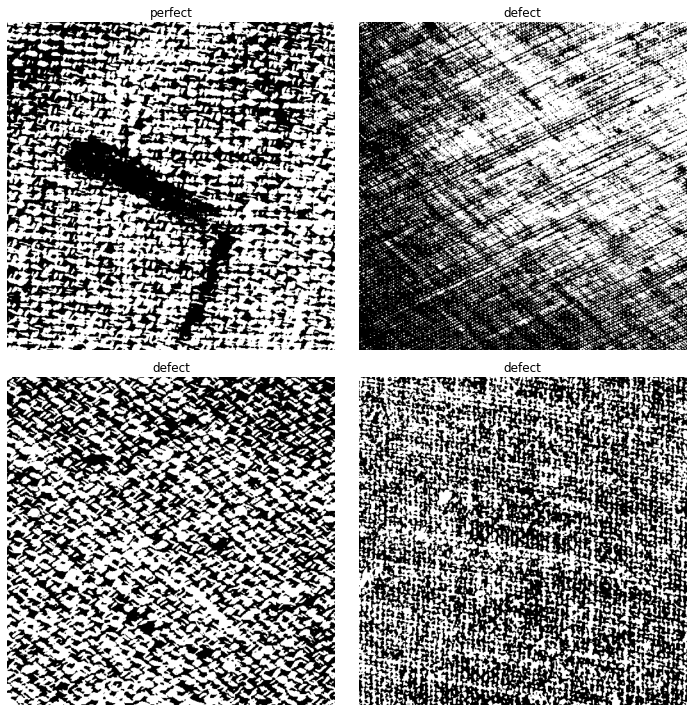

In [89]:
# Plot a grid of images.
PLOT_IMAGES = 4
images = []
labels_class = []

_image_j = PLOT_IMAGES
while _image_j > 0:
    _train_gen = train_pipeline

    _I_BATCH = np.random.randint(len(_train_gen) // BATCH_SIZE)
    i = np.random.randint(BATCH_SIZE)
    images.append(_train_gen[_I_BATCH][0][i]) # n Images from train generator.
    labels_class.append(target_classes[int(np.argwhere(_train_gen[_I_BATCH][1][i] > 0))]) # The correspondent name
    _image_j -= 1
    
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for img, ax, lab in zip(images, axes, labels_class):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(lab)
plt.tight_layout()
plt.show()

# Transformer training

## Import pretrained VIT model from Keras

In [90]:
# pretrained_model = vit.vit_b16(
#         image_size = IMG_SIZE[0],
#         activation = 'softmax',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         classes = len(target_classes))
# pretrained_model.trainable = False

# model = tf.keras.Sequential([
#             pretrained_model,
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(len(target_classes) // 2, activation = tfa.activations.gelu),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(1, 'softmax')
#         ], name = f'transfer_learning')

## Import pretrained CNN model from Keras

In [91]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import layers

def get_cnn_pretrained(batch_normalization: bool = True, dropout_rate: float = 0.) -> tf.keras.Model:
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    pretrained_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")
    # freeze the pretrained weights
    pretrained_model.trainable = False
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(pretrained_model.output)
    
    if batch_normalization:
        x = layers.BatchNormalization()(x)  
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)
    
    fcc_layer = layers.Dense(len(target_classes), activation="softmax", name="pred")
    outputs = fcc_layer(x)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

### Alternatively, we built it from scratch

In [102]:
def get_cnn_scratch(batch_normalization: bool = True, dropout_rate: float = 0.) -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(len(target_classes), activation="softmax"),], name = f'cnn_from_scratch')
    
    return model

In [104]:
model = get_cnn_scratch()
model.summary()  # it is really long in case of the pretrained CNN

Model: "cnn_from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 512, 512, 8)       224       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 32)   

## Compiling the model 

In [105]:
optimizer = 'adam'  # tfa.optimizers.RectifiedAdam(learning_rate=5e-2) # Creates the optimizer using rectified ADAM.
_loss_function = 'BCE'  # tf.keras.losses.BinaryCrossentropy(from_logits=False)  # 'logloss'  # 'BCE'

In [106]:
model.compile(optimizer=optimizer, loss = _loss_function, metrics = ['accuracy', 'AUC'])

STEP_SIZE_TRAIN = train_pipeline.n // train_pipeline.batch_size
STEP_SIZE_VALID = valid_pipeline.n // valid_pipeline.batch_size

# Dynamic Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'min')
# Early stopping
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 1e-4,
                                                 patience = 3,
                                                 mode = 'min',
                                                 restore_best_weights = True,
                                                 verbose = 1)
# Checkpoint. Save the model.
# checkpointer = tf.keras.callbacks.ModelCheckpoint(
#     filepath = '/kaggle/working/model.hdf5', monitor = 'val_accuracy', verbose = 1, 
#     save_best_only = True, save_weights_only = True, mode = 'max')

callbacks = [earlystopping, reduce_lr]  # , ]  # , checkpointer] # Our callbacks

## Training the model

In [108]:
from tensorflow.keras.models import save_model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
EPOCHS: int = 25
MODEL_NAME: str = 'cnn_from_scratch'  # 'serialized_model' 

history = model.fit(
    x=train_pipeline, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_pipeline, validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks, epochs=EPOCHS,  # EPOCHS,
    )

save_model(model, f'/kaggle/working/{MODEL_NAME}.h5')

Epoch 1/25
166/166 [==============================] - 68s 408ms/step - loss: 0.4737 - accuracy: 0.7767 - auc: 0.8598 - val_loss: 0.3366 - val_accuracy: 0.8125 - val_auc: 0.9317
Epoch 2/25
166/166 [==============================] - 67s 404ms/step - loss: 0.3886 - accuracy: 0.8264 - auc: 0.9148 - val_loss: 0.3662 - val_accuracy: 0.8929 - val_auc: 0.9508
Epoch 3/25
166/166 [==============================] - 68s 407ms/step - loss: 0.3259 - accuracy: 0.8550 - auc: 0.9376 - val_loss: 0.2986 - val_accuracy: 0.8482 - val_auc: 0.9435
Epoch 4/25
166/166 [==============================] - 67s 402ms/step - loss: 0.2998 - accuracy: 0.8678 - auc: 0.9458 - val_loss: 0.2687 - val_accuracy: 0.8393 - val_auc: 0.9550
Epoch 5/25
166/166 [==============================] - 66s 399ms/step - loss: 0.2616 - accuracy: 0.8867 - auc: 0.9584 - val_loss: 0.2147 - val_accuracy: 0.8839 - val_auc: 0.9615
Epoch 6/25
166/166 [==============================] - 67s 402ms/step - loss: 0.2314 - accuracy: 0.9006 - auc: 0.967

RuntimeError: File size unexpectedly exceeded ZIP64 limit

## Inference 

In [119]:
from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/serialized.h5')
y_prob_train = model.predict(train_pipeline, steps = train_pipeline.n // train_pipeline.batch_size + 1)
y_prob_valid = model.predict(valid_pipeline, steps = valid_pipeline.n // valid_pipeline.batch_size + 1)
y_prob_test = model.predict(test_pipeline, steps = test_pipeline.n // test_pipeline.batch_size + 1)

[[9.3286626e-02 9.0671343e-01]
 [8.1792736e-04 9.9918205e-01]
 [9.9999940e-01 5.8087852e-07]
 ...
 [9.7518414e-01 2.4815843e-02]
 [3.7818652e-02 9.6218139e-01]
 [1.4862256e-01 8.5137743e-01]]


Exception: STOP

## Result analysis & plots

In [112]:
predicted_classes_train = np.argmax(y_prob_train, axis = 1)
predicted_classes_valid = np.argmax(y_prob_valid, axis = 1)
predicted_classes_test = np.argmax(y_prob_test, axis = 1)

# class_labels = list(true_pipeline.class_indices.keys())  

print('\n' + 3 * "---", 'TRAIN', 3 * '---')
print(classification_report(train_pipeline.classes, predicted_classes_train))
print('\n' + 3 * "---", 'VALIDATION', 3 * '---')
print(classification_report(valid_pipeline.classes, predicted_classes_valid))
print('\n' + 3 * "---", 'TEST', 3 * '---')
print(classification_report(test_pipeline.classes, predicted_classes_test))


--------- TRAIN ---------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2064
           1       0.25      0.26      0.25       592

    accuracy                           0.66      2656
   macro avg       0.52      0.52      0.52      2656
weighted avg       0.66      0.66      0.66      2656


--------- VALIDATION ---------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       178
           1       0.24      0.26      0.25        46

    accuracy                           0.68       224
   macro avg       0.53      0.53      0.53       224
weighted avg       0.69      0.68      0.69       224


--------- TEST ---------
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       110
           1       0.18      0.23      0.20        30

    accuracy                           0.61       140
   macro avg       0.48      0.47      0.47

### Confusion matrix

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Training

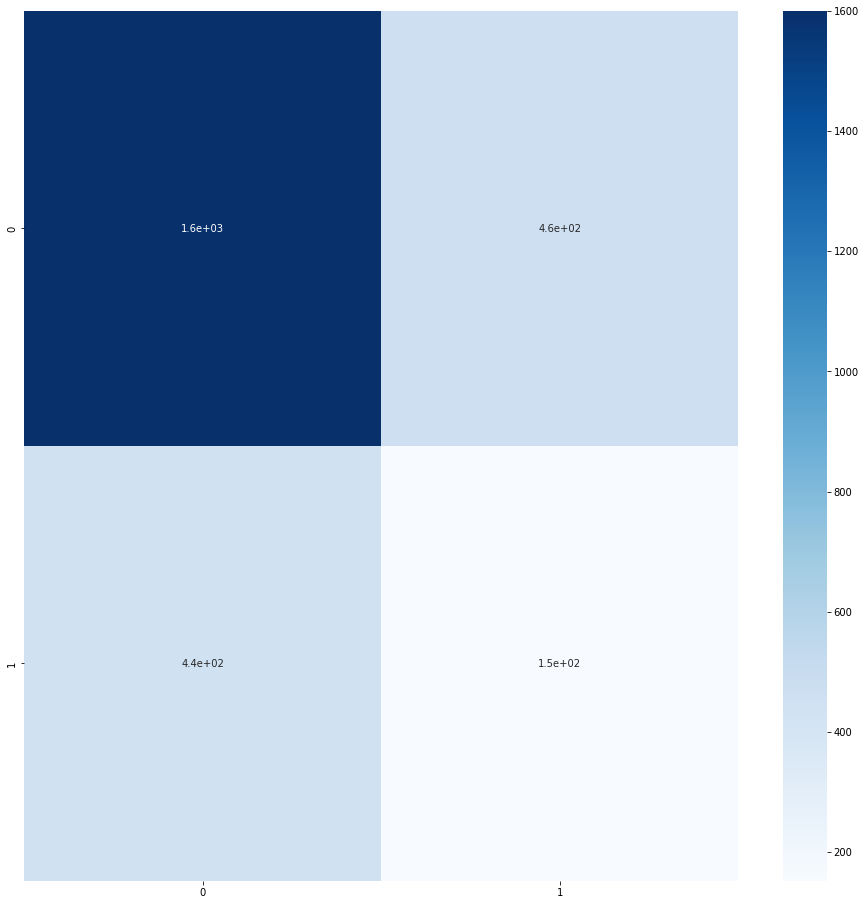

In [114]:
confusionmatrix = confusion_matrix(train_pipeline.classes, predicted_classes_train)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_train.png')

#### Validation

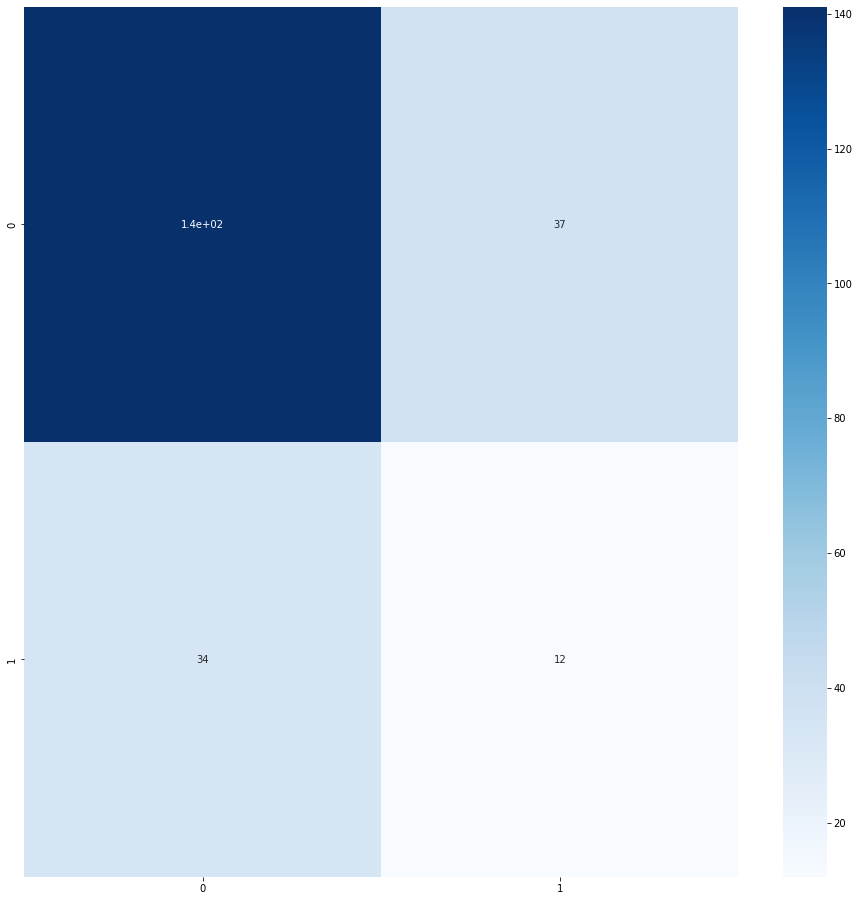

In [115]:
confusionmatrix = confusion_matrix(valid_pipeline.classes, predicted_classes_valid)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_validation.png')

#### Test

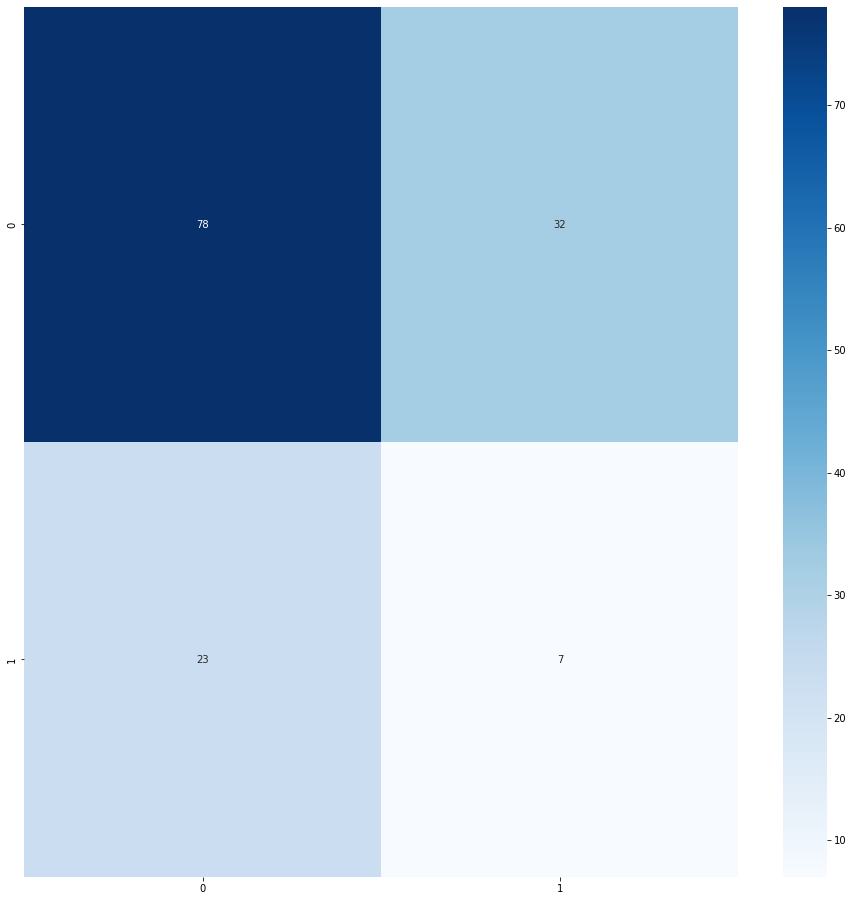

In [116]:
confusionmatrix = confusion_matrix(test_pipeline.classes, predicted_classes_test)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.savefig('/kaggle/working/cmatrix_test.png')

### ROC curve

In [117]:
from sklearn import metrics

def compute_roc_and_auc(y_true,  y_pred_proba):
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba,)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    return fpr, tpr, auc

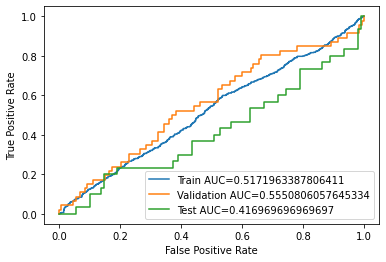

In [118]:
fpr_train, tpr_train, auc_train = compute_roc_and_auc(train_pipeline.classes, y_prob_train[:, 1])
fpr_valid, tpr_valid, auc_valid = compute_roc_and_auc(valid_pipeline.classes, y_prob_valid[:, 1])
fpr_test, tpr_test, auc_test = compute_roc_and_auc(test_pipeline.classes, y_prob_test[:, 1])

#create ROC curve
plt.plot(fpr_train, tpr_train, label=f"Train AUC="+str(auc_train))
plt.plot(fpr_valid, tpr_valid, label=f"Validation AUC="+str(auc_valid))
plt.plot(fpr_test, tpr_test, label=f"Test AUC="+str(auc_test))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('/kaggle/working/ROC.png')
plt.show()